In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# Setup matplotlib to display in notebook:
%matplotlib inline

In [3]:
df_prorated_imputed = pd.read_pickle("../output/NYCHA_Electricity_2010_to_2018_df_prorated_kwh_imputed")
df_prorated_imputed.head()

,Building_Meter,Month,Month_Type,Month_#_Days,Prorated_Days,Gap_Days,Gap_Type,Prorated_KWH,Imputed_KWH
0,165.0 - BLD 04_99273488,2009-12-01,First_Month,31,9.0,0.0,No Gap,19694.117647,67835.294118
1,165.0 - BLD 04_99273488,2010-01-01,Month_In_The_Middle,31,31.0,0.0,No Gap,68283.025210,68283.025210
2,165.0 - BLD 04_99273488,2010-02-01,Month_In_The_Middle,28,28.0,0.0,No Gap,61071.133005,61071.133005
3,165.0 - BLD 04_99273488,2010-03-01,Month_In_The_Middle,31,31.0,0.0,No Gap,58011.118077,58011.118077
4,165.0 - BLD 04_99273488,2010-04-01,Month_In_The_Middle,30,30.0,0.0,No Gap,55164.054336,55164.054336


In [4]:
#df_one_building = df_prorated_imputed[df_prorated_imputed['Building_Meter']=='368.0 - BLD 02_8383053']
df_one_building = df_prorated_imputed[df_prorated_imputed['Building_Meter']=='165.0 - BLD 03_90327795']
#df_one_building = df_prorated_imputed[df_prorated_imputed['Building_Meter']=='165.0 - BLD 04_99273488']

In [5]:
df_one_building = df_one_building.reset_index()

In [6]:
def sliding_chunker(data, window_len, slide_len):
    """
    Split a list into a series of sub-lists, each sub-list window_len long,
    sliding along by slide_len each time. If the list doesn't have enough
    elements for the final sub-list to be window_len long, the remaining data
    will be dropped.
    e.g. sliding_chunker(range(6), window_len=3, slide_len=2)
    gives [ [0, 1, 2], [2, 3, 4] ]
    """
    chunks = []
    for pos in range(0, len(data), slide_len):
        chunk = np.copy(data[pos:pos+window_len])
        if len(chunk) != window_len:
            continue
        chunks.append(chunk)

    return chunks

In [7]:
def plot_waves(waves, step):
    """
    Plot a set of 9 waves from the given set, starting from the first one
    and increasing in index by 'step' for each subsequent graph
    """
    plt.figure()
    n_graph_rows = 3
    n_graph_cols = 3
    graph_n = 1
    wave_n = 0
    for _ in range(n_graph_rows):
        for _ in range(n_graph_cols):
            axes = plt.subplot(n_graph_rows, n_graph_cols, graph_n)
            axes.set_ylim([min(df_one_building['Imputed_KWH'])-10000, max(df_one_building['Imputed_KWH'])+10000])
            plt.plot(waves[wave_n])
            graph_n += 1
            wave_n += step
    # fix subplot sizes so that everything fits
    plt.suptitle('Waveform Segments of 8 data points')
    plt.tight_layout(pad=2,h_pad=1)
    plt.show()

In [8]:
def reconstruct(data, window, clusterer):
    """
    Reconstruct the given data using the cluster centers from the given
    clusterer.
    """
    window_len = len(window)
    slide_len = window_len/2
    segments = sliding_chunker(data, window_len, slide_len)
    reconstructed_data = np.zeros(len(data))
    for segment_n, segment in enumerate(segments):
        # window the segment so that we can find it in our clusters which were
        # formed from windowed data
        segment *= window
        nearest_match_idx = clusterer.predict(segment)[0]
        nearest_match = np.copy(clusterer.cluster_centers_[nearest_match_idx])

        pos = segment_n * slide_len
        reconstructed_data[pos:pos+window_len] += nearest_match

    return reconstructed_data

In [9]:
segment_len = 8
slide_len = 1

segments = []
for start_pos in range(0, len(df_one_building['Imputed_KWH']), slide_len):
    end_pos = start_pos + segment_len
    # make a copy so changes to 'segments' doesn't modify the original data
    segment = np.copy(df_one_building['Imputed_KWH'][start_pos:end_pos])
    # if we're at the end and we've got a truncated segment, drop it
    if len(segment) != segment_len:
        continue
    segments.append(segment)

print("Produced %d waveform segments" % len(segments))

Produced 96 waveform segments


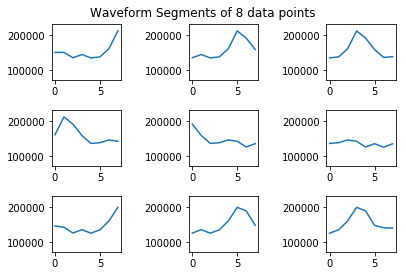

In [10]:
plot_waves(segments, step=2)

In [11]:
from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=12)
clusterer.fit(segments)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

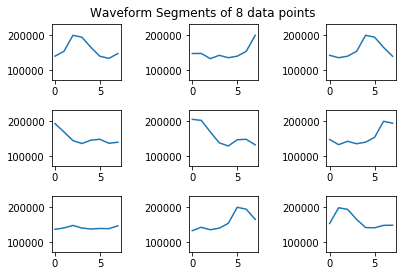

In [12]:
plot_waves(clusterer.cluster_centers_, step=1)

In [13]:
slide_len = 1
test_segments = sliding_chunker(
    df_one_building['Imputed_KWH'],
    window_len=segment_len,
    slide_len=slide_len
)

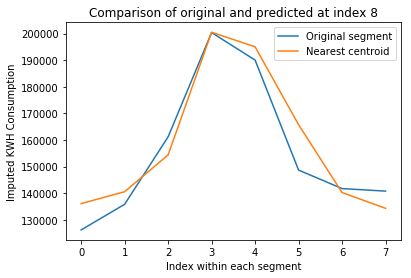

In [14]:
centroids = clusterer.cluster_centers_

segment = np.copy(test_segments[16])
# predict() returns a list of centres to cope with the possibility of multiple
# samples being passed
nearest_centroid_idx = clusterer.predict(test_segments[16].reshape(1,-1))[0]
nearest_centroid = np.copy(centroids[nearest_centroid_idx])
plt.figure()
plt.plot(segment, label="Original segment");
plt.plot(nearest_centroid, label="Nearest centroid");
plt.title('Comparison of original and predicted at index 8');
plt.xlabel('Index within each segment');
plt.ylabel('Imputed KWH Consumption');
plt.legend();
plt.show();

### Reconstruction

Maximum reconstruction error was 46065.7
99th percentile of reconstruction error was 22309.6


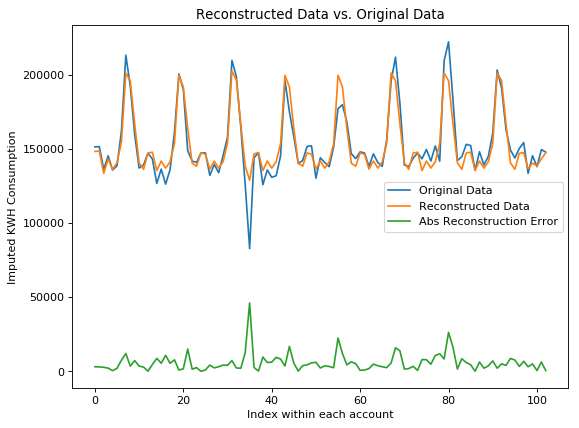

In [15]:
data = df_one_building['Imputed_KWH']
reconstruction = np.zeros(len(data))


for segment_n, segment in enumerate(test_segments):
    # don't modify the data in segments
    segment = np.copy(segment)
    nearest_centroid_idx = clusterer.predict(segment.reshape(1,-1))[0]
    centroids = clusterer.cluster_centers_
    nearest_centroid = np.copy(centroids[nearest_centroid_idx])
    
    # overlay our reconstructed segments with an overlap of half a segment
    pos = int(segment_n * slide_len)
    reconstruction[pos:pos+segment_len] += nearest_centroid/(segment_len/slide_len)
#     if 8 > pos and 8 < pos+segment_len:
#          plt.plot(np.linspace(1,8,8)+pos, nearest_centroid,label = pos)

# fix first segment_len and last segment_len data points since they are not modeled segment_len/slide_len times
for i in np.linspace(0,segment_len-1,segment_len).astype(int):
    reconstruction[i] = reconstruction[i]/(i+1)*(segment_len/slide_len)
    reconstruction[-i -1 ] = reconstruction[-i - 1]/(i+1)*(segment_len/slide_len)

n_plot_samples = len(data)
error = reconstruction[0:n_plot_samples] - data[0:n_plot_samples]
error_99th_percentile = np.percentile(error, 99)
print("Maximum reconstruction error was %.1f" % error.max())
print("99th percentile of reconstruction error was %.1f" % error_99th_percentile)

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(data[0:n_plot_samples], label="Original Data")
plt.plot(reconstruction[0:n_plot_samples], label="Reconstructed Data")
plt.plot(np.abs(error[0:n_plot_samples]), label="Abs Reconstruction Error")
plt.title('Reconstructed Data vs. Original Data');
plt.xlabel('Index within each account');
plt.ylabel('Imputed KWH Consumption');
plt.legend();
plt.show();

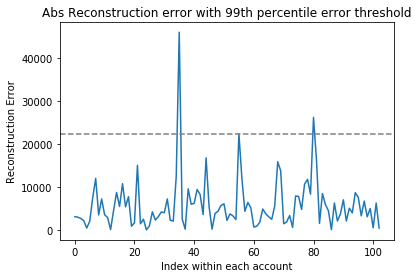

In [16]:
plt.plot(np.abs(error[0:n_plot_samples]), label="Reconstruction Error")
plt.axhline(y=error_99th_percentile,linestyle='--',color='gray');
plt.title('Abs Reconstruction error with 99th percentile error threshold');
plt.xlabel('Index within each account');
plt.ylabel('Reconstruction Error');
plt.show();

In [17]:
anomaly_entries = df_one_building[np.abs(error[0:n_plot_samples])>error_99th_percentile]
anomaly_entries

,index,Building_Meter,Month,Month_Type,Month_#_Days,Prorated_Days,Gap_Days,Gap_Type,Prorated_KWH,Imputed_KWH
35,344,165.0 - BLD 03_90327795,2012-11-01,Month_In_The_Middle,30,30.0,0.0,No Gap,82710.303030,82710.303030
55,364,165.0 - BLD 03_90327795,2014-07-01,Month_In_The_Middle,31,31.0,0.0,No Gap,177073.777778,177073.777778
80,389,165.0 - BLD 03_90327795,2016-08-01,Month_In_The_Middle,31,31.0,0.0,No Gap,222030.000000,222030.000000


In [18]:
df_one_building['Anomaly'] = np.where(np.abs(error[0:n_plot_samples])>error_99th_percentile, 'Yes', 'No')

In [19]:
output = df_one_building[df_one_building['Anomaly']=='Yes'][['Building_Meter','Month','Month_Type','Imputed_KWH','Anomaly']]

In [20]:
output['Error'] = error[df_one_building['Anomaly']=='Yes']
output['Reconstructed Value'] = reconstruction[df_one_building['Anomaly']=='Yes']

In [21]:
output[['Building_Meter','Month','Imputed_KWH','Reconstructed Value','Error','Anomaly']]

,Building_Meter,Month,Imputed_KWH,Reconstructed Value,Error,Anomaly
35,165.0 - BLD 03_90327795,2012-11-01,82710.303030,128775.999053,46065.696023,Yes
55,165.0 - BLD 03_90327795,2014-07-01,177073.777778,199496.012152,22422.234374,Yes
80,165.0 - BLD 03_90327795,2016-08-01,222030.000000,195807.855102,-26222.144898,Yes


### Define function and Loop through all accounts

In [22]:
def clustering_reconstruction(df_one_building):
    
    segment_len = 8
    slide_len = 1

    segments = []
    for start_pos in range(0, len(df_one_building['Imputed_KWH']), slide_len):
        end_pos = start_pos + segment_len
        # make a copy so changes to 'segments' doesn't modify the original data
        segment = np.copy(df_one_building['Imputed_KWH'][start_pos:end_pos])
        # if we're at the end and we've got a truncated segment, drop it
        if len(segment) != segment_len:
            continue
        segments.append(segment)
        
    clusterer = KMeans(n_clusters=12)
    clusterer.fit(segments)
        
    data = df_one_building['Imputed_KWH']
    reconstruction = np.zeros(len(data))


    test_segments = sliding_chunker(
        df_one_building['Imputed_KWH'],
        window_len=segment_len,
        slide_len=slide_len
    )


    for segment_n, segment in enumerate(test_segments):
        # don't modify the data in segments
        segment = np.copy(segment)
        nearest_centroid_idx = clusterer.predict(segment.reshape(1,-1))[0]
        centroids = clusterer.cluster_centers_
        nearest_centroid = np.copy(centroids[nearest_centroid_idx])

        # overlay our reconstructed segments with an overlap of half a segment
        pos = int(segment_n * slide_len)
        reconstruction[pos:pos+segment_len] += nearest_centroid/(segment_len/slide_len)
    #     if 8 > pos and 8 < pos+segment_len:
    #          plt.plot(np.linspace(1,8,8)+pos, nearest_centroid,label = pos)

    # fix first segment_len and last segment_len data points since they are not modeled segment_len/slide_len times
    for i in np.linspace(0,segment_len-1,segment_len).astype(int):
        reconstruction[i] = reconstruction[i]/(i+1)*(segment_len/slide_len)
        reconstruction[-i -1 ] = reconstruction[-i - 1]/(i+1)*(segment_len/slide_len)

    n_plot_samples = len(data)
    error = reconstruction[0:n_plot_samples] - data[0:n_plot_samples]
    error_99th_percentile = np.percentile(error, 99)
    
    df_one_building['Anomaly'] = np.where(np.abs(error[0:n_plot_samples])>error_99th_percentile, 'True', 'False')
    df_one_building['Error'] = error
    df_one_building['Reconstructed Value'] = reconstruction
    
    return df_one_building

In [23]:
valid_account = pd.read_csv("../output/NYCHA_Accounts_More_Than_50_Months.csv")

In [24]:
%%time
result = []
for account in valid_account.loc[:,'Account_Name']: 

    df_one_building = df_prorated_imputed[df_prorated_imputed['Building_Meter']==account]
#     df_one_building = df_one_building.reset_index()
    
#     if len(df_one_building) > 100:
#         continue
    df_one_building_result = clustering_reconstruction(df_one_building)
    
    result.append(df_one_building_result)
    
result = pd.concat(result, axis=0)

/Users/crystal-pro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/crystal-pro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/crystal-pro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

CPU times: user 5min 54s, sys: 632 ms, total: 5min 54s
Wall time: 5min 55s


In [25]:
result.shape

(178108, 12)

In [26]:
result.head()

,Building_Meter,Month,Month_Type,Month_#_Days,Prorated_Days,Gap_Days,Gap_Type,Prorated_KWH,Imputed_KWH,Anomaly,Error,Reconstructed Value
123086,1.0 - BLD 01_7836716,2009-12-01,First_Month,31,8.0,0.0,No Gap,212.363636,822.909091,False,67.909618,890.818709
123087,1.0 - BLD 01_7836716,2010-01-01,Month_In_The_Middle,31,31.0,0.0,No Gap,805.236364,805.236364,False,-6.484910,798.751453
123088,1.0 - BLD 01_7836716,2010-02-01,Month_In_The_Middle,28,28.0,0.0,No Gap,680.606897,680.606897,False,67.793165,748.400062
123089,1.0 - BLD 01_7836716,2010-03-01,Month_In_The_Middle,31,31.0,0.0,No Gap,853.147942,853.147942,False,-121.686348,731.461594
123090,1.0 - BLD 01_7836716,2010-04-01,Month_In_The_Middle,30,30.0,0.0,No Gap,715.645161,715.645161,False,-17.937256,697.707905


In [44]:
#result_summary = result.pivot_table('Building_Meter','Anomaly').mean()
result_summary = pd.pivot_table(result,
                                index = ['Building_Meter'],
                                aggfunc = 'count',
                                columns = 'Anomaly',
                                values = 'Month')


result_summary

Anomaly,False,True
Building_Meter,,
1.0 - BLD 01_7836716,99.0,4.0
1.0 - BLD 01_7838586,100.0,3.0
1.0 - BLD 02_7694040,100.0,3.0
1.0 - BLD 03_7177432,98.0,5.0
1.0 - BLD 04_7381828,98.0,5.0
1.0 - BLD 05_6889487,100.0,3.0
1.0 - BLD 06_6469176,100.0,3.0
1.0 - BLD 07_7006908,72.0,1.0
10.0 - BLD 01_7864550,100.0,2.0


In [46]:
result_summary.to_csv('../output/summary_clustering.csv')